# Data Analysis agentic workflow v1

No report generation agent

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys

current_path = os.getcwd()  # Current working directory
root_path = os.path.abspath(os.path.join(current_path, os.pardir))
sys.path.append(root_path)

---


## Graph structure


In [3]:
from langgraph.graph import END, StateGraph, START

from src.utils.models import GraphState
from src.nodes import (
    summarization_node,
    grade_query,
    grade_visualization_requirement,
    data_query_node,
    chart_node,
)

In [4]:
workflow = StateGraph(GraphState)

In [5]:
# Define the nodes
workflow.add_node("summarize_data", summarization_node)
workflow.add_node("grade_query", grade_query)
workflow.add_node("grade_visualization_requirement", grade_visualization_requirement)
workflow.add_node("data_query_node", data_query_node)
workflow.add_node("chart_node", chart_node)

In [6]:
from src.tools import decide_to_continue, decide_to_visualize

In [7]:
# Build graph
workflow.add_edge(START, "summarize_data")
workflow.add_edge("summarize_data", "grade_query")
workflow.add_conditional_edges(
    "grade_query",
    decide_to_continue,
    {
        "query_not_relevant": END,
        "query_relevant": "grade_visualization_requirement",
    },
)
workflow.add_conditional_edges(
    "grade_visualization_requirement",
    decide_to_visualize,
    {
        "not_visualize": "data_query_node",
        "visualize": "chart_node",
    },
)
workflow.add_edge("data_query_node", END)
workflow.add_edge("chart_node", END)

In [8]:
# Compile
app = workflow.compile()

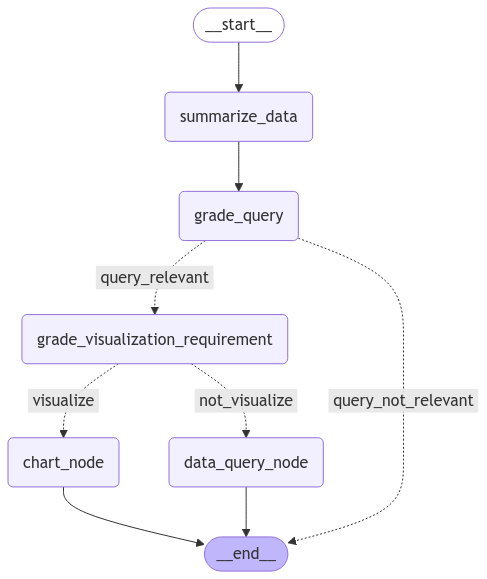

In [9]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

---


## Testing the workflow


In [10]:
def process_question(query: str, file: str, metadata: str) -> None:
    """
    Process the question and generate the final output

    Args:
        query: The question to be processed
        file: The file name of the data
    """
    data_path = os.path.join(root_path, "data", file)

    inputs = {"query": query, "data_path": data_path, "metadata": metadata}

    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Node '{key}':")
        print("====== END OF NODE ======\n")

    print("====== FINAL GENERATION ======")
    if "generation" in value:
        print(value["generation"])
    else:
        print("Data not found")

### Testing query related to data, which doesnot require visualization

In [11]:
process_question(
    query="Which is the most expensive comedy movie?", 
    file="tmdb_movies_data.csv",
    metadata=""
)

====== SUMMARIZATION NODE ======
Node 'summarize_data':
====== END OF NODE ======

====== CHECK USER QUERY RELEVANCE ======
====== GRADE: USER QUERY RELEVANT ======
====== ASSERT DATA RELEVANCE ======

====== DECISION: DATA RELATED, CHECK IF VISUALIZATION REQUIRED ======

Node 'grade_query':
====== END OF NODE ======

====== CHECK VISUALIZATION REQUIREMENT ======
====== GRADE: USER QUERY DOES NOT REQUIRE VISUALIZATION ======
====== DECIDE TO VISUALIZE ======
====== DECISION: NO VISUALIZATION REQUIRED ======

Node 'grade_visualization_requirement':
====== END OF NODE ======

====== DATA QUERY NODE ======
Generation:
{'answer': "Based on the original budget, 'Men in Black 3' is the most expensive comedy movie.  However, considering the budget adjusted for inflation, 'Wild Wild West' is the most expensive.", 'charts': []}
Node 'data_query_node':
====== END OF NODE ======

====== FINAL GENERATION ======
{'answer': "Based on the original budget, 'Men in Black 3' is the most expensive comedy

### Testing query unrelated to data

In [12]:
process_question(
    query="Who is the most skilled player?", 
    file="tmdb_movies_data.csv",
    metadata=""
)

====== SUMMARIZATION NODE ======
Node 'summarize_data':
====== END OF NODE ======

====== CHECK USER QUERY RELEVANCE ======
====== GRADE: USER QUERY NOT RELEVANT ======
====== ASSERT DATA RELEVANCE ======

====== DECISION: DATA NOT RELATED, END ======

Node 'grade_query':
====== END OF NODE ======

====== FINAL GENERATION ======
Data not found


### Testing query related to data, which require visualization

In [13]:
process_question(
    query="Do comedy movies make more money then Action movie ? Visualize",
    file="tmdb_movies_data.csv",
    metadata=""
)

====== SUMMARIZATION NODE ======
Node 'summarize_data':
====== END OF NODE ======

====== CHECK USER QUERY RELEVANCE ======
====== GRADE: USER QUERY RELEVANT ======
====== ASSERT DATA RELEVANCE ======

====== DECISION: DATA RELATED, CHECK IF VISUALIZATION REQUIRED ======

Node 'grade_query':
====== END OF NODE ======

====== CHECK VISUALIZATION REQUIREMENT ======
====== GRADE: USER QUERY REQUIRES VISUALIZATION ======
====== DECIDE TO VISUALIZE ======
====== DECISION: VISUALIZATION REQUIRED ======

Node 'grade_visualization_requirement':
====== END OF NODE ======

====== CHART NODE ======
Node 'chart_node':
====== END OF NODE ======

====== FINAL GENERATION ======
{'answer': 'No, Action movies have generated more adjusted revenue than Comedy movies.', 'charts': []}
